In [25]:
# The directory for top level folder
dir_ = "/home/sugam/Work/20-29 Deep Learning/22 Projects/Optimization of Energy Using AIML/data/"

In [26]:
raw_data_dir = dir_ + 'raw/'
processed_data_dir = dir_+'Processed/'

# 1. MAIN SETUP

In [27]:
# Genderal imports 
import numpy as np
import pandas as pd
import os, sys, gc,time,warnings,pickle,psutil,random
from math import ceil
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import mplcatppuccin
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(["ggplot", "mocha"])
plt.rcParams["figure.figsize"] = (25,8)
warnings.filterwarnings("ignore")

In [28]:
############################# MEMORY PROFILER
## Displays memory used by dataframe

def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [29]:
########################## MEMORY REDUCER
## Function which checks each column and manage the dtype automatically


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:5.2f} Mb {(100 * (start_mem - end_mem) / start_mem):.1f}% reduction')
    return df

In [30]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1,df2,merge_on):
    merged_df = df1[merge_on] # merge_on is multiple columns
    merged_df = merged_df.merge(df2,on=merge_on,how='left')
    new_columns = [col for col in list(merged_df) if col not in merge_on]
    df1 = pd.concat([df1,merged_df[new_columns]],axis=1)
    return df1

In [31]:
######################### Vars
###################################################################
TARGET = ["load"] # main target -> Going to combine every load to a single variable
END_TRAIN = '2020-12-04 23:45:00' # Last day of train set
MAIN_INDEX = ['date'] # Identify each entry by these columns

# 2. PART -1 

In [32]:
####################### LOAD DATA
##################################################################
def load_data(url: str) ->pd.DataFrame:
    """
    Loads the dataframe into memory

    Args:
      url (string) - the path to the dataframe

    Returns:
      df (pandas dataframe)
    """
    
    print("⏳ Load Data")
    
    # Refering our data without any modification and dtype
    df = pd.read_csv(url,
                           index_col=0,
                           parse_dates = True)

    for col in list(df):  # List out the column names
        if "Unnamed" in col:  # Checks if the column contains Unnamed in it 
            df.drop(col, axis=1,inplace=True) # Removes the Garbage column
    
    #df.drop_duplicates(subset='date',inplace=True)

    df.index = pd.to_datetime(df.index,format='mixed',dayfirst=True) # Converting index to date time format
    
    print("✅ Load Data")
    
    return df


train_df_dir = raw_data_dir+"01 Energy Usage Data/energy_usage.csv"
weather_df_dir = raw_data_dir+"02 Outdoor Environmental Data/site_weather.csv"

train_df = load_data(train_df_dir)
weather_df = load_data(weather_df_dir)

⏳ Load Data
✅ Load Data
⏳ Load Data
✅ Load Data


In [33]:
def add_all_columns(train_df: pd.DataFrame)-> pd.DataFrame:
    """
    Takes a main dataframe and adds up all the columns to make a single load column

    Args:
      train_df (pandas dataframe) - Original dataframe

    Returns:
      train_df (pandas dataframe) - dataframe with a single load column
    """
    
    # Combining all North wings and South wing load into a single variables
    train_df["load"] = (train_df['Mis_elect_load_south']+
                           train_df['light_load_south']+
                           train_df['hvac_load_south']+
                           train_df['Mis_elect_load_north']+
                           train_df['hvac_load_north']
                          )
    
    train_df.drop(['Mis_elect_load_south',
                   'light_load_south',
                   'hvac_load_south',
                   'Mis_elect_load_north',
                   'hvac_load_north']
                  ,axis=1,
                 inplace=True)

    return train_df
    

train_df = add_all_columns(train_df)

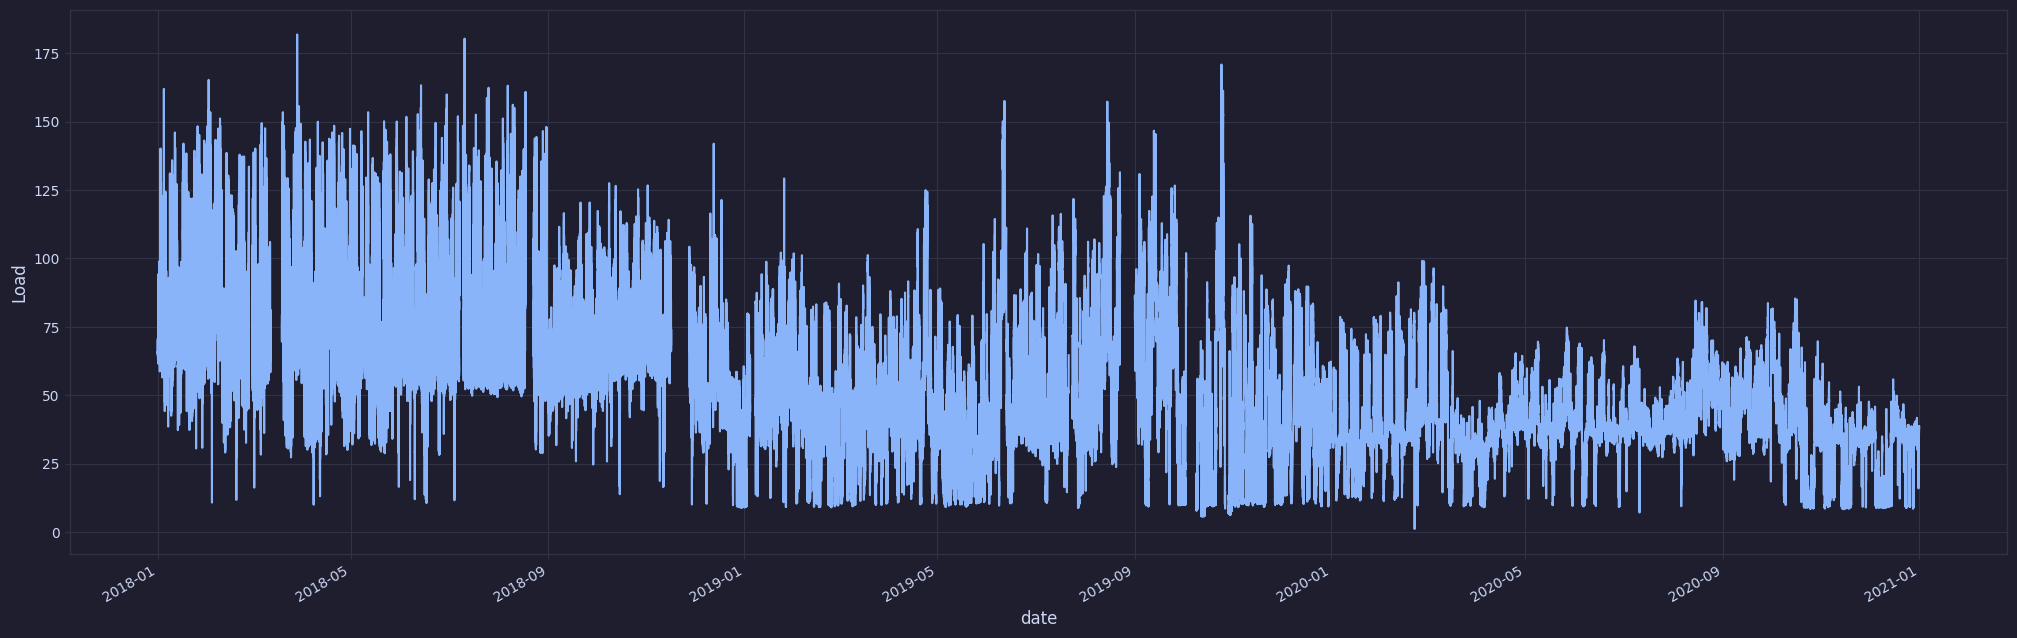

In [34]:
train_df["load"].plot()
plt.ylabel("Load");

Text(0, 0.5, 'Load')

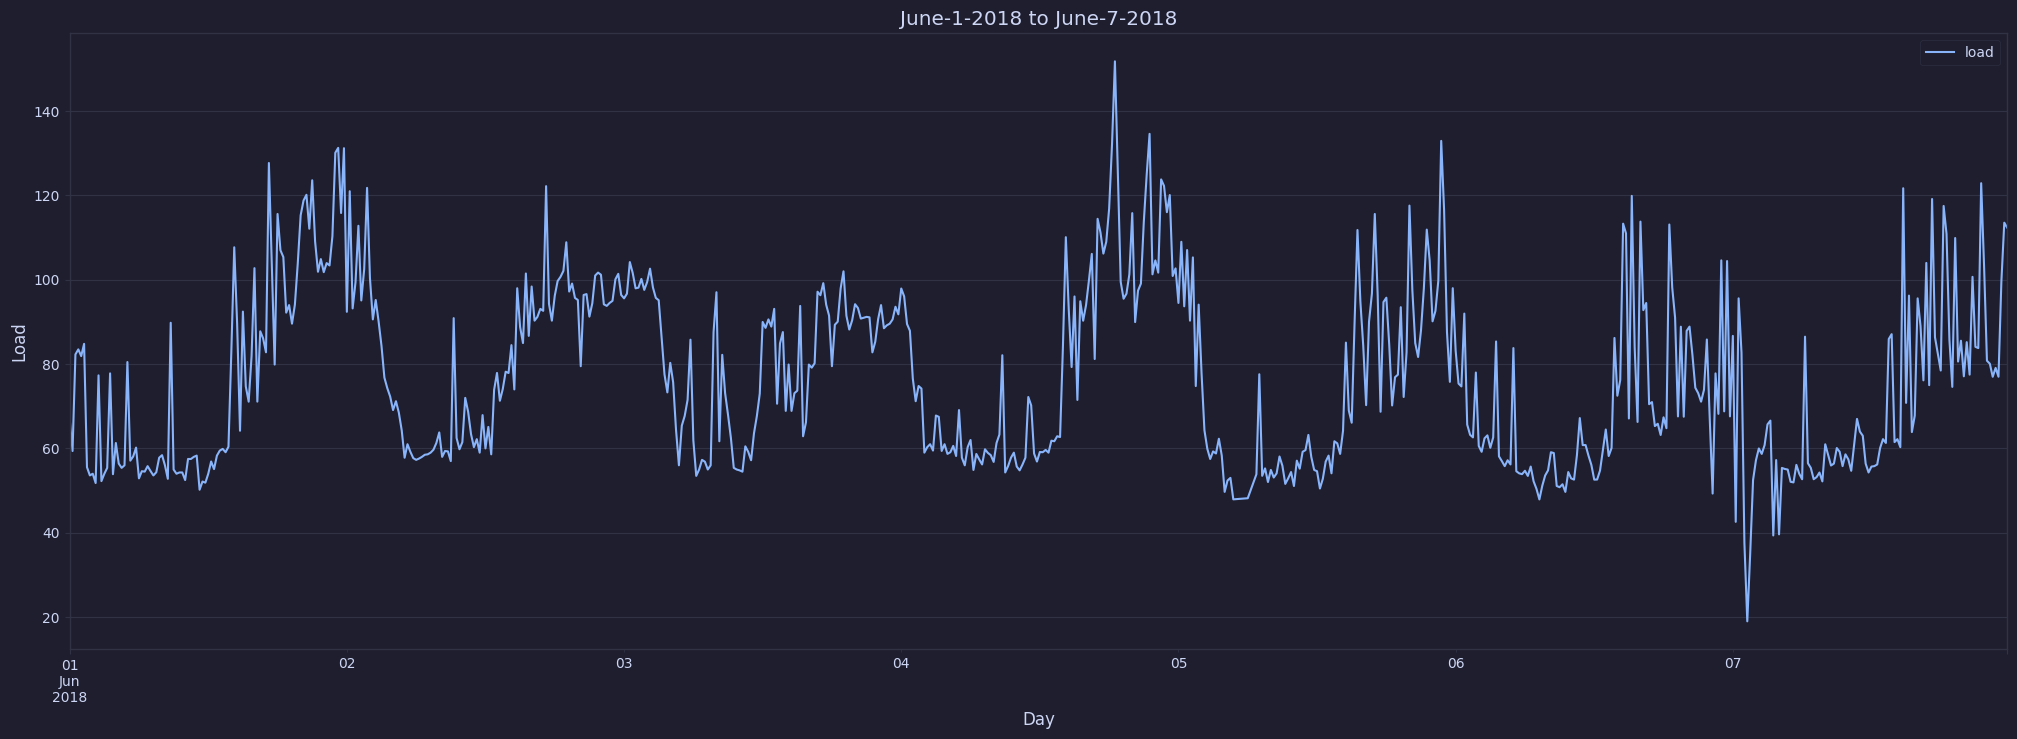

In [35]:
# Looking at 1 week worth of data from June-01-2018 to June-07-2018
train_df.loc["2018-06-01":"2018-06-07"].plot()
plt.title("June-1-2018 to June-7-2018");
plt.xlabel("Day")
plt.ylabel("Load")

In [36]:
def create_basic_date_column(df):
    """
    Takes the dataframe and creates columns like year, month, day, hour and minute from datetime index

    Args:
      df (pandas dataframe) - original dataframe

    Returns:
      df (pandas dataframe) - dataframe with added columns
    """
    
    df["year"] = df.index.year
    df["month"] = df.index.month.astype(np.int8)
    df["day"] = df.index.day.astype(np.int8)
    df["hour"] = df.index.hour.astype(np.int8)
    df["minute"] = df.index.minute.astype(np.int8)
    
    return df

In [38]:
def create_columns(df):
    """
    Takes the dataframe and adds the extra column
    Args:
      df (pandas dataframe) - Original dataframe

    Return:
      df (pandas dataframe) - dataframe with added columns
    """
    # Monday = 0 , Sunday = 6
    df["weekday"] = train_df.index.weekday.astype(np.int8)
    
    
    # This adds number of week in a month
    df["week_num"] = df["day"].apply(lambda x: ceil(x/7)).astype(np.int8)

    # Friday saturday and sunday are weekends = 1 , everything else is 0
    df["is_weekdend"] = df.index.weekday.map(lambda x: 1 if x>=5 else 0)
    
    df["load_min"] = df.groupby(["year","month","week_num"])["load"].transform("min")
    df["load_max"] = df.groupby(["year","month","week_num"])["load"].transform("max")
    df["load_mean"] = df.groupby(["year","month","week_num"])["load"].transform("mean")
    df["load_std"] = df.groupby(["year","month","week_num"])["load"].transform("std")
    # Normalize the energy (min/max scaling)
    df["load_norm"] = df["load"] / ((df["load_max"]-df["load_min"])+1e-5) 
        
    return df

train_df = create_basic_date_column(train_df)
train_df = create_columns(train_df)
train_df = train_df.iloc[:-1,:] # Since last day was creating inf

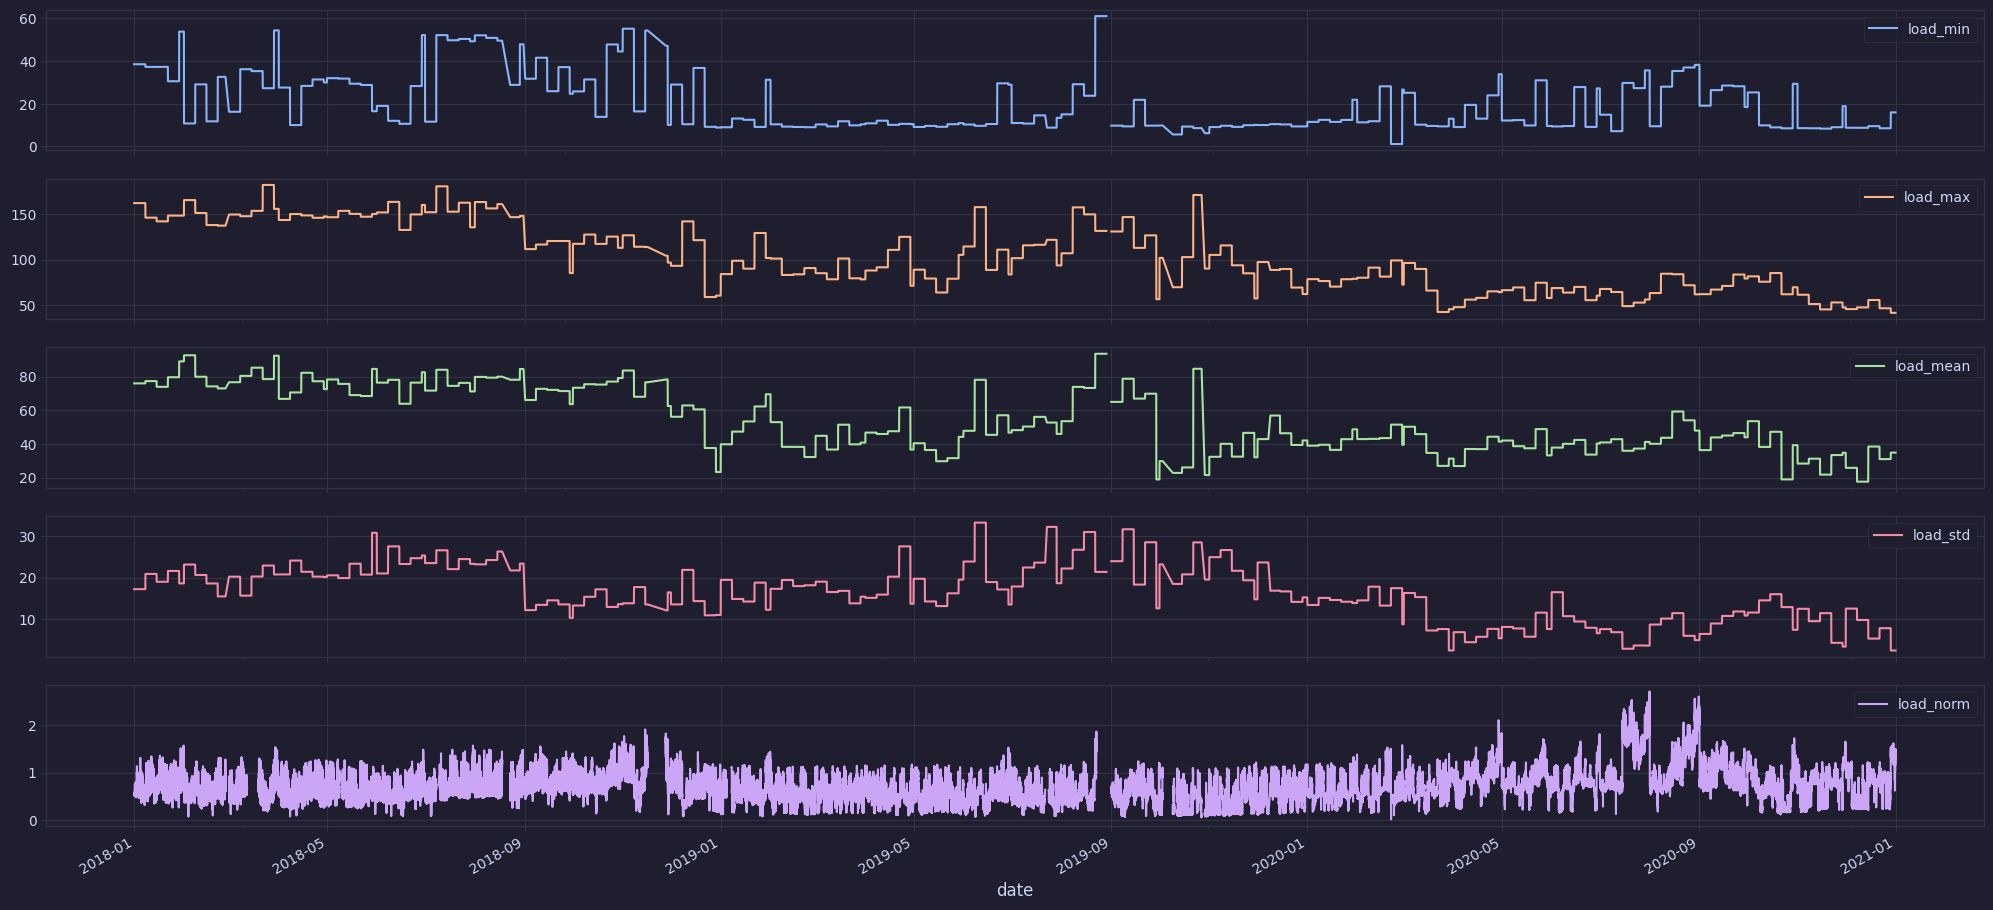

In [40]:
train_df[["load_min","load_max","load_mean","load_std","load_norm"]].plot(subplots=True,figsize=(25,12));

In [41]:
train_df.reset_index(drop=True,inplace=True) # Drop the date index

In [42]:
def remove_na(df: pd.DataFrame)->pd.DataFrame:
    """
    Checks for the null values if found then fills it wil the average load value of the particular month

    Args:
      df (pandas dataframe) - the original dataframe

    Returns:
      df (pandas dataframe) - dataframe with na values filled with the average values from that particular month
    
    """
    is_null = len(df.isnull().sum(axis=0)[df.isnull().sum(axis=0)>0]) > 0 
    if is_null:
        month_wise_mean = df.groupby(["year","month"])["load"].transform("mean")
        df["load"].fillna(month_wise_mean, inplace=True)
        del month_wise_mean
    df.fillna(method = "bfill",inplace=True)   
    
    return df

train_df = remove_na(train_df)

In [43]:
train_df.fillna(method="ffill",inplace=True)
train_df.isnull().sum()


load           0
year           0
month          0
day            0
hour           0
minute         0
weekday        0
week_num       0
is_weekdend    0
load_min       0
load_max       0
load_mean      0
load_std       0
load_norm      0
dtype: int64

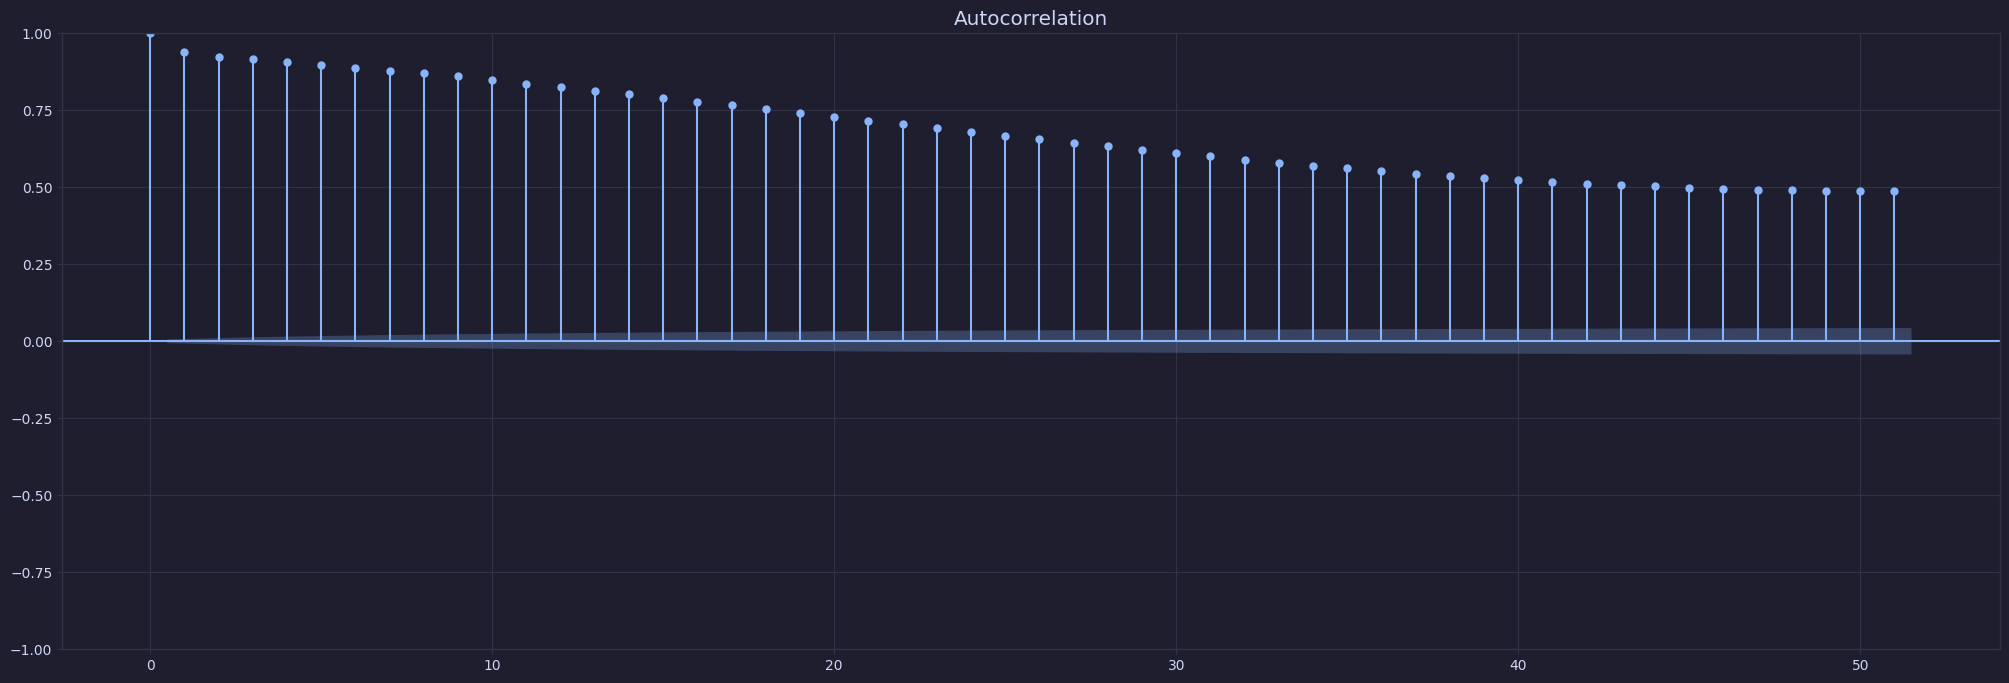

In [44]:
plot_acf(train_df["load"]);

In [45]:
# Reducing the size of the dataframe
print("{}: {}".format('Original',sizeof_fmt(train_df.memory_usage(index=True).sum())))

train_df = reduce_mem_usage(train_df)

print("{}: {}".format('After reducing',sizeof_fmt(train_df.memory_usage(index=True).sum())))


Original: 6.1MiB
Mem. usage decreased to  2.06 Mb 66.1% reduction
After reducing: 2.1MiB


In [46]:
############################# Save the Dataframe
print("✅ Save part 1")
train_df.to_pickle(processed_data_dir+"train_df_part_1.pkl")

✅ Save part 1


# 3. Part 2

In [47]:
weather_df = load_data(weather_df_dir)

⏳ Load Data
✅ Load Data


In [48]:
weather_df["dew_point_temperature_sensor_2"] = weather_df["dew_point_temperature_sensor_2"].replace("`",np.nan)
weather_df.fillna(method = 'bfill',inplace = True)

In [49]:
weather_df = create_basic_date_column(weather_df)

In [ ]:
main_cols = ["air_temp_sensor_1","air_temp_sensor_2","dew_point_temperature_sensor_2","relative_humidity_sensor_1","solar_radiation_sensor_1"] 
weather_df[main_cols].plot(subplots=True);

In [ ]:
def preprocess_columns(df):
    
    df["avg_air_temp"] = weather_df[["air_temp_sensor_1","air_temp_sensor_2"]].mean(axis=1)

    df.drop(["air_temp_sensor_1","air_temp_sensor_2"],axis=1,inplace=True)
    
    df.reset_index(drop=True,inplace=True) # Removing the date index
    
    df.rename(columns={"dew_point_temperature_sensor_2": "dew_point_temp",
                      "relative_humidity_sensor_1": "relative_humidity",
                      "solar_radiation_sensor_1": "solar_radiation"},
                     inplace=True)

    return df

weather_df = preprocess_columns(weather_df)

In [ ]:
process_cols = ["avg_air_temp","dew_point_temp","relative_humidity","solar_radiation"] 
weather_df[process_cols].plot(subplots=True);

In [ ]:
weather_df = reduce_mem_usage(weather_df)
train_df = reduce_mem_usage(train_df)

In [28]:
##################################3 Merge and save to part 2
print("Merge Weather and save it for part 2")

merge_on = ["year","month","day","hour","minute"]
train_df = train_df.merge(weather_df,
                          on =merge_on,
                          how="left")

print("✅ Save part 2")
train_df.to_pickle(processed_data_dir+"train_df_part_2.pkl")

del train_df

Merge Weather and save it for part 2
✅ Save part 2


# Lag Feature

In [29]:
df = pd.read_pickle(processed_data_dir+"train_df_part_1.pkl")
df.head()

,load,year,month,day,hour,minute,weekday,week_num,is_weekdend,load_min,load_max,load_mean,load_std,load_norm
0,65.8125,2018,1,1,1,0,0,1,0,38.53125,162.0,75.9375,17.234375,0.532950
1,65.6875,2018,1,1,1,15,0,1,0,38.53125,162.0,75.9375,17.234375,0.532059
2,66.0000,2018,1,1,1,30,0,1,0,38.53125,162.0,75.9375,17.234375,0.534570
3,65.1875,2018,1,1,1,45,0,1,0,38.53125,162.0,75.9375,17.234375,0.528010
4,70.6875,2018,1,1,2,0,0,1,0,38.53125,162.0,75.9375,17.234375,0.572638


In [30]:
# We only need year, month, day , hour , minute and load
df = df[["year","month","day","hour","minute","load"]]
SHIFT_DAY = 1

# Lags with 1 day
start_time = time.time()
print("Create Lags")

LAG_DAYS = [col for col in range(SHIFT_DAY, SHIFT_DAY+15)]
df = df.assign(**{
    "{}_lag_{}".format(col,l): df[col].shift(l)
    for l in LAG_DAYS
    for col in TARGET
})
print('%0.2f minute: Lags' % ((time.time() - start_time) / 60))

Create Lags
0.00 minute: Lags


In [31]:
for col in df:
    if "lag" in col:
        df[col] = df[col].astype(np.float16)

In [32]:
start_time = time.time()
print('Create rolling aggs')

for i in [7,14,30,60,180]:
    print('Rolling period:', i)
    df['rolling_mean_'+str(i)] = df[TARGET].shift(SHIFT_DAY).rolling(i).mean().astype(np.float16)
    df['rolling_std_'+str(i)]  = df[TARGET].shift(SHIFT_DAY).rolling(i).std().astype(np.float16)

# Rollings
# with sliding shift
for d_shift in [1,7,14]: 
    print('Shifting period:', d_shift)
    for d_window in [7,14,30,60]:
        col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
        df[col_name] = df[TARGET].shift(d_shift).rolling(d_window).mean().astype(np.float16)
    
    
print('%0.2f minute: Lags' % ((time.time() - start_time) / 60))

Create rolling aggs
Rolling period: 7
Rolling period: 14
Rolling period: 30
Rolling period: 60
Rolling period: 180
Shifting period: 1
Shifting period: 7
Shifting period: 14
0.00 minute: Lags


In [33]:
df.fillna(0,inplace=True)

In [34]:
########################### Export
#################################################################################
print('Save lags and rollings')
df.to_pickle(processed_data_dir+'lags_df_'+str(SHIFT_DAY)+'.pkl')

Save lags and rollings


In [35]:
########################## Combine train_df_1 and Lags
train_df_part_1 = pd.read_pickle(processed_data_dir+"train_df_part_1.pkl")

# Combined the original energy df -> train_df_part_1 and the df with lag features
# Storing the combined form into train_df_energy
train_df_energy = train_df_part_1.merge(df,on=["year","month","day","hour","minute"],how = "left")
train_df_energy.rename({"load_x":"load"},inplace=True)
train_df_energy.drop("load_y",axis=1,inplace=True)

print("Saving final Energy df")
train_df_energy.to_pickle(processed_data_dir+"train_df_energy_final.pkl")

Saving final Energy df
